In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sets the global parameters for Scanpy

# 0: no log output.
# 1: basic information
# 2: Additional information
# 3: detailed inofrmation
sc.settings.verbosity = 0

# for plots
sc.settings.set_figure_params(dpi=80, facecolor="white")

### 1. Load the data

In [3]:
adata = sc.datasets.pbmc3k()
print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


### 2. Quality Control

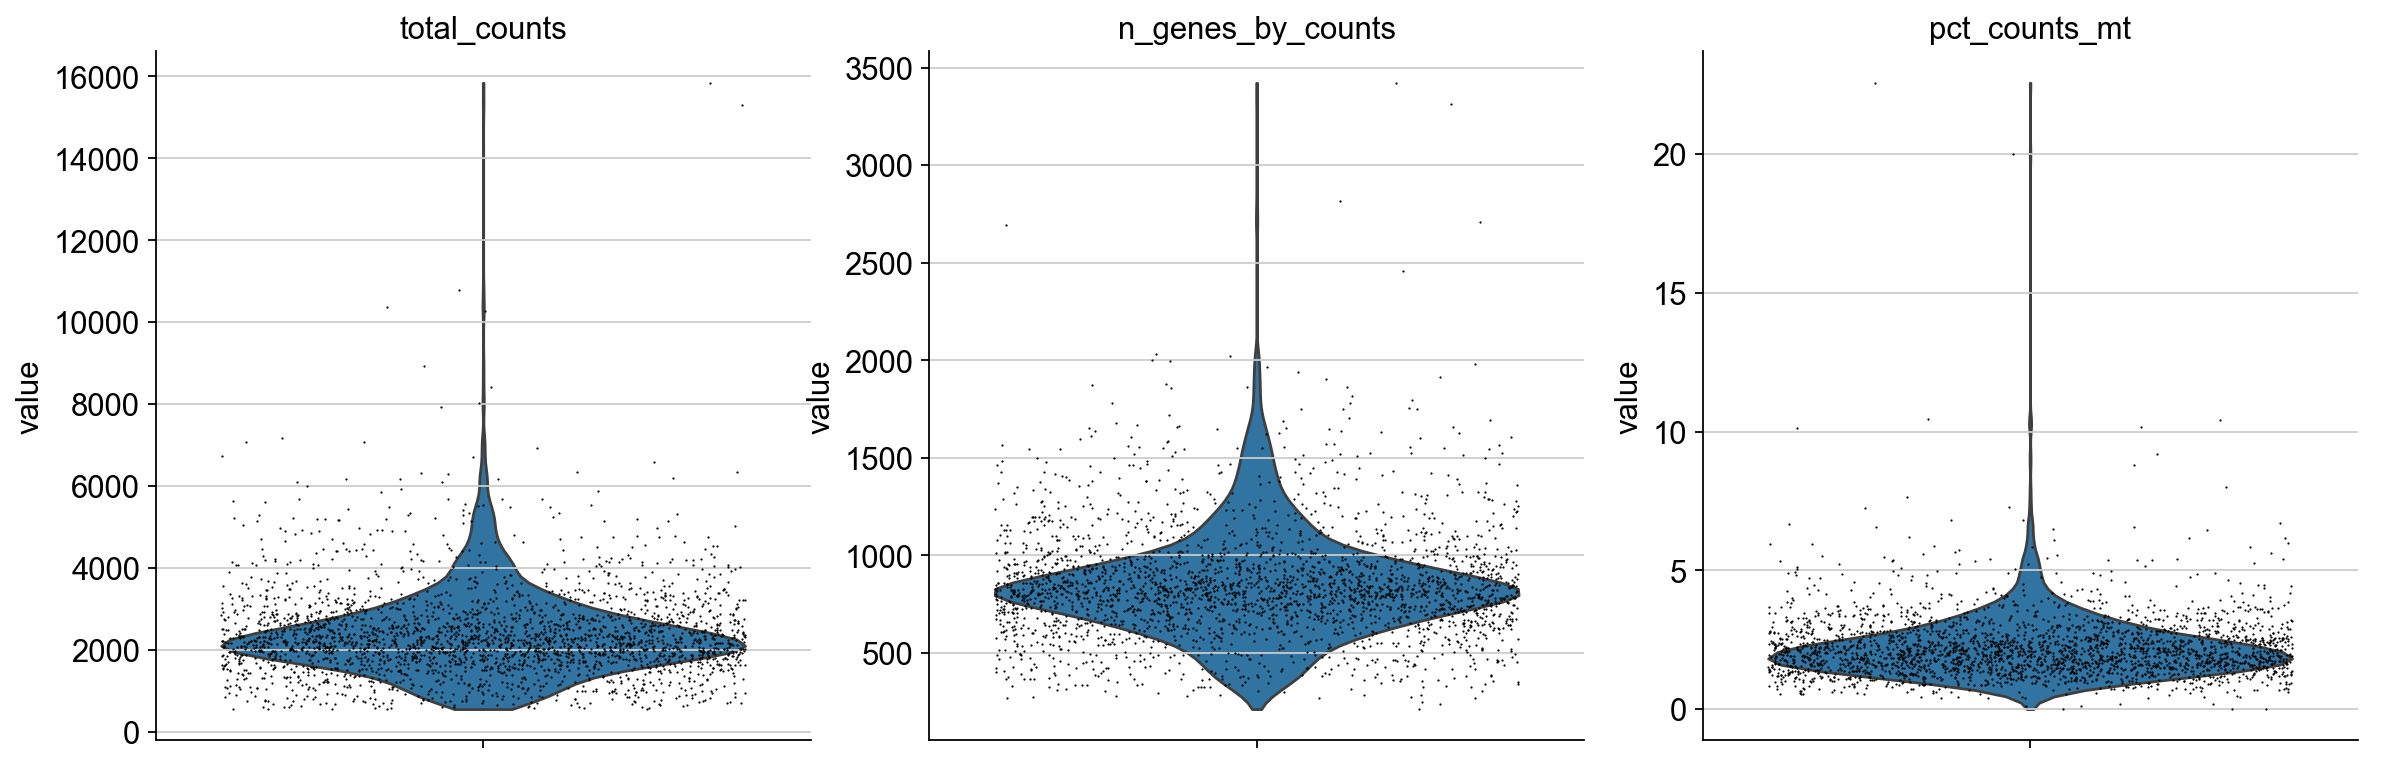

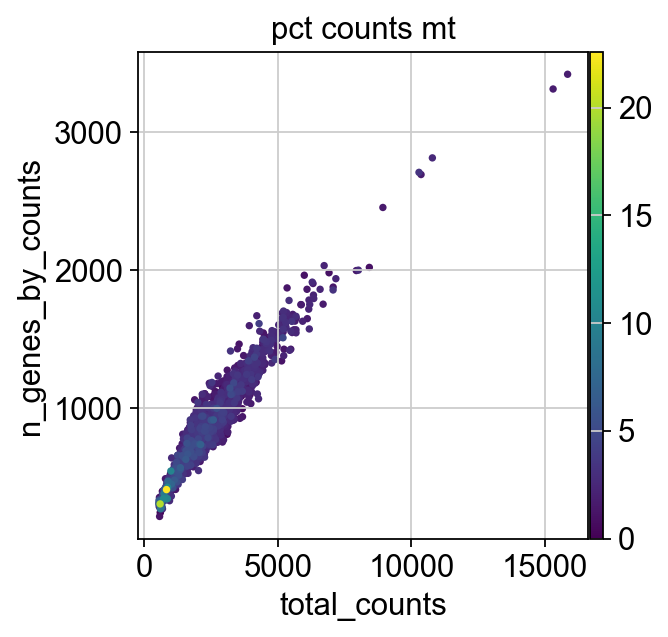

In [4]:
# Check which genes in the dataset are mitochondrial genes.
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

# Draw the violin plots to check the distribution.
sc.pl.violin(
    adata,
    ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# scatter plot for pct_counts_mt
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


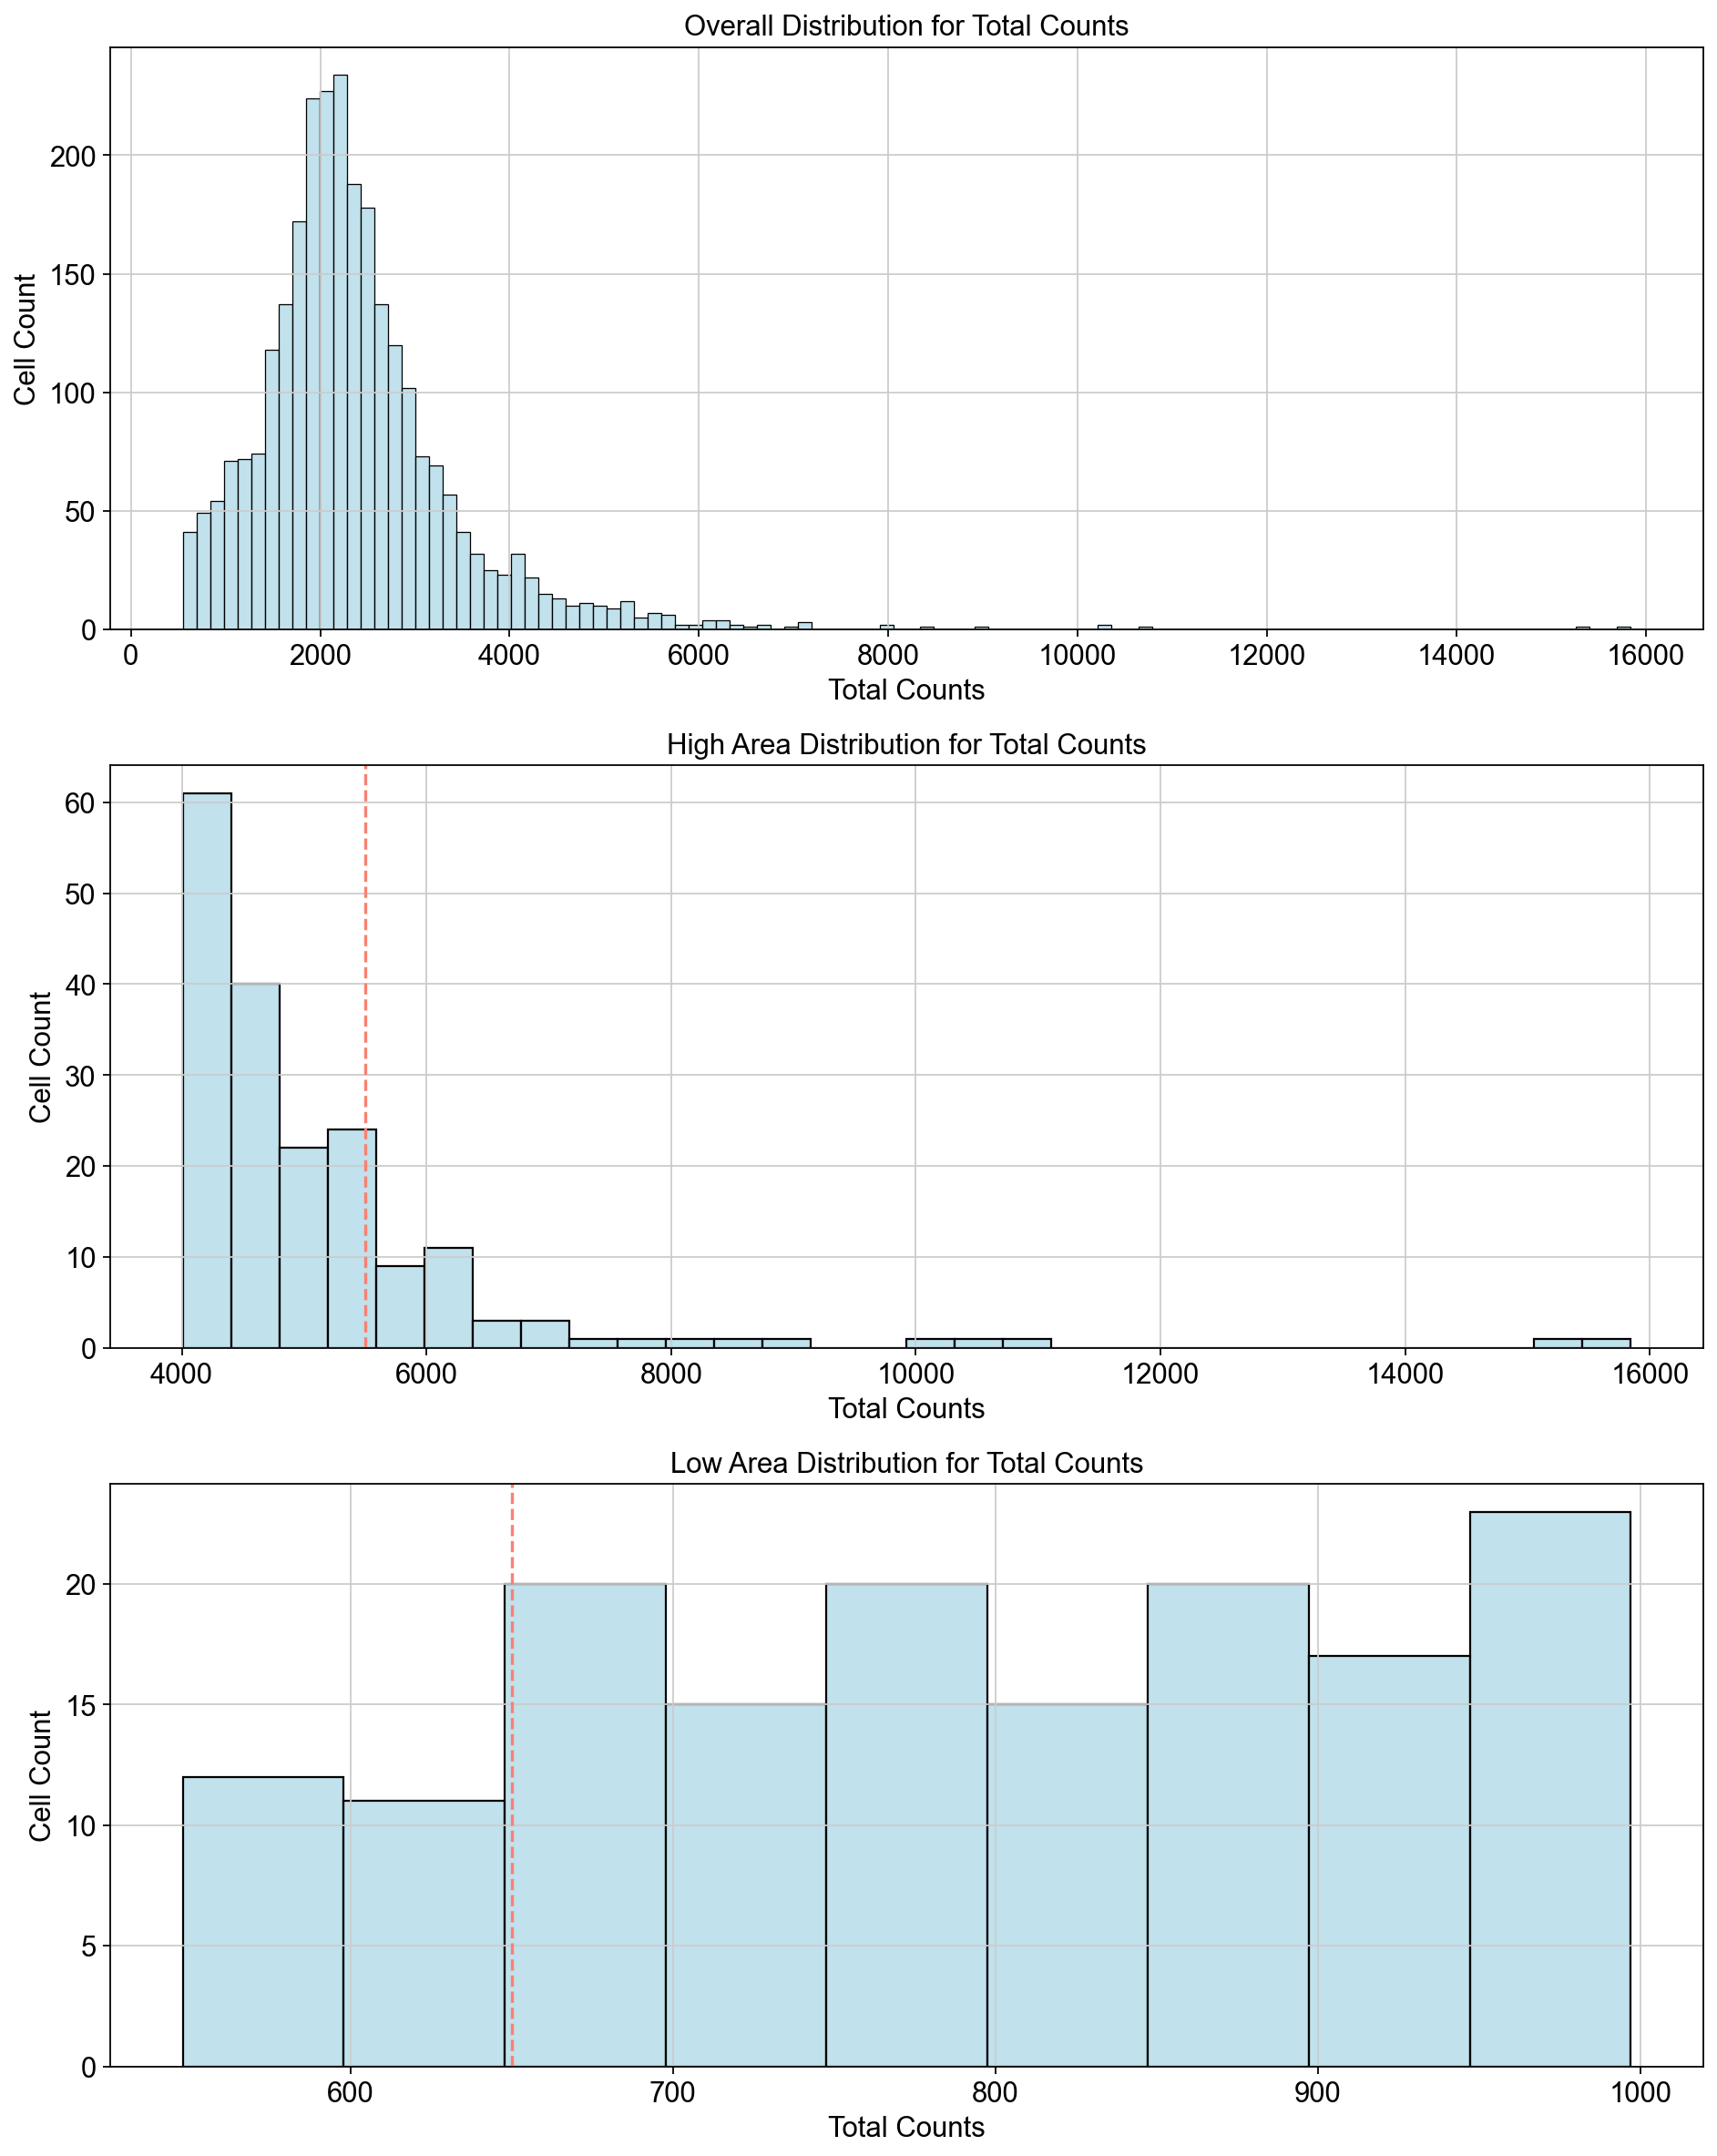

In [5]:
# Total Count distribution
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Overall
sns.histplot(adata.obs["total_counts"], ax=axes[0], color="lightblue")
axes[0].set_title("Overall Distribution for Total Counts")
axes[0].set_xlabel("Total Counts")
axes[0].set_ylabel("Cell Count")

# High area
high_total_counts = adata.obs["total_counts"][adata.obs["total_counts"] > 4000]
sns.histplot(high_total_counts, ax=axes[1], color="lightblue")
axes[1].set_title("High Area Distribution for Total Counts")
axes[1].set_xlabel("Total Counts")
axes[1].set_ylabel("Cell Count")
axes[1].axvline(x=5500, color='salmon', linestyle='--')

# Low area
low_total_counts = adata.obs["total_counts"][adata.obs["total_counts"] < 1000]
sns.histplot(low_total_counts, ax=axes[2], color="lightblue")
axes[2].set_title("Low Area Distribution for Total Counts")
axes[2].set_xlabel("Total Counts")
axes[2].set_ylabel("Cell Count")
axes[2].axvline(x=650, color='salmon', linestyle='--')

plt.tight_layout()
plt.show()


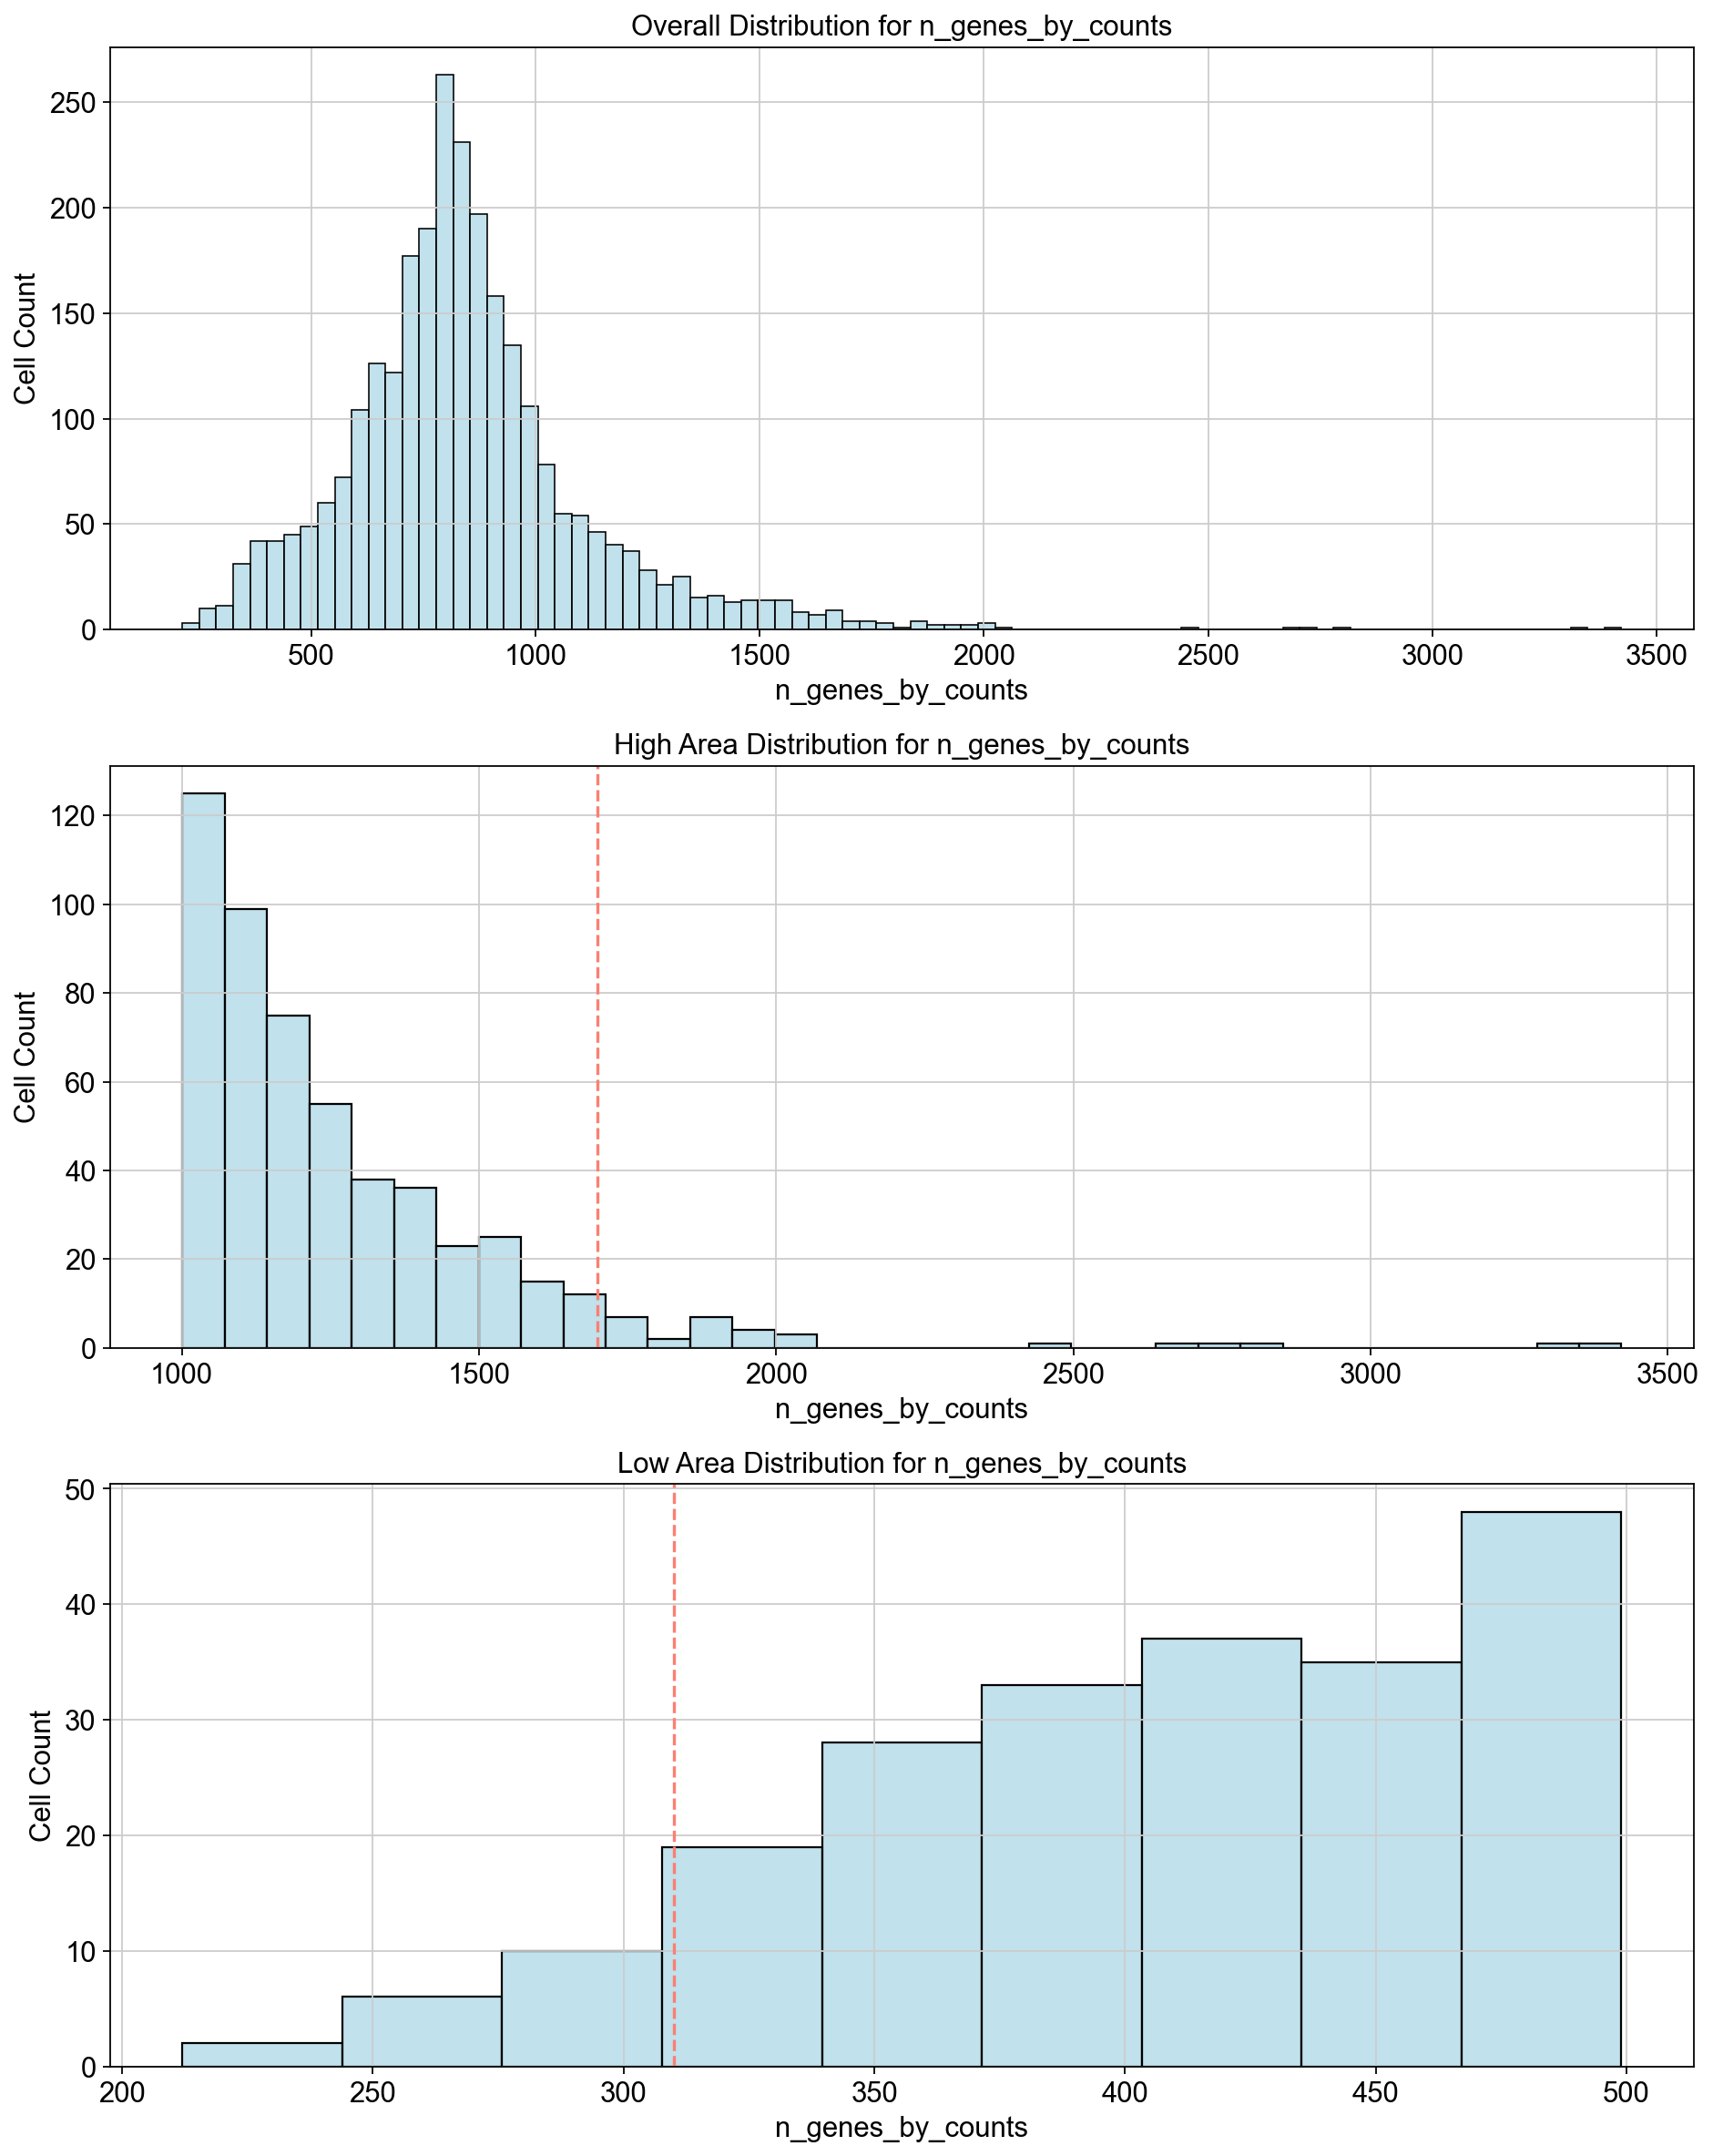

In [6]:
# Total Count distribution
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Overall
sns.histplot(adata.obs["n_genes_by_counts"], ax=axes[0], color="lightblue")
axes[0].set_title("Overall Distribution for n_genes_by_counts")
axes[0].set_xlabel("n_genes_by_counts")
axes[0].set_ylabel("Cell Count")

# High area
high_genes_counts = adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] > 1000]
sns.histplot(high_genes_counts, ax=axes[1], color="lightblue")
axes[1].set_title("High Area Distribution for n_genes_by_counts")
axes[1].set_xlabel("n_genes_by_counts")
axes[1].set_ylabel("Cell Count")
axes[1].axvline(x=1700, color='salmon', linestyle='--')

# Low area
low_genes_counts = adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 500]
sns.histplot(low_genes_counts, ax=axes[2], color="lightblue")
axes[2].set_title("Low Area Distribution for n_genes_by_counts")
axes[2].set_xlabel("n_genes_by_counts")
axes[2].set_ylabel("Cell Count")
axes[2].axvline(x=310, color='salmon', linestyle='--')


plt.tight_layout()
plt.show()


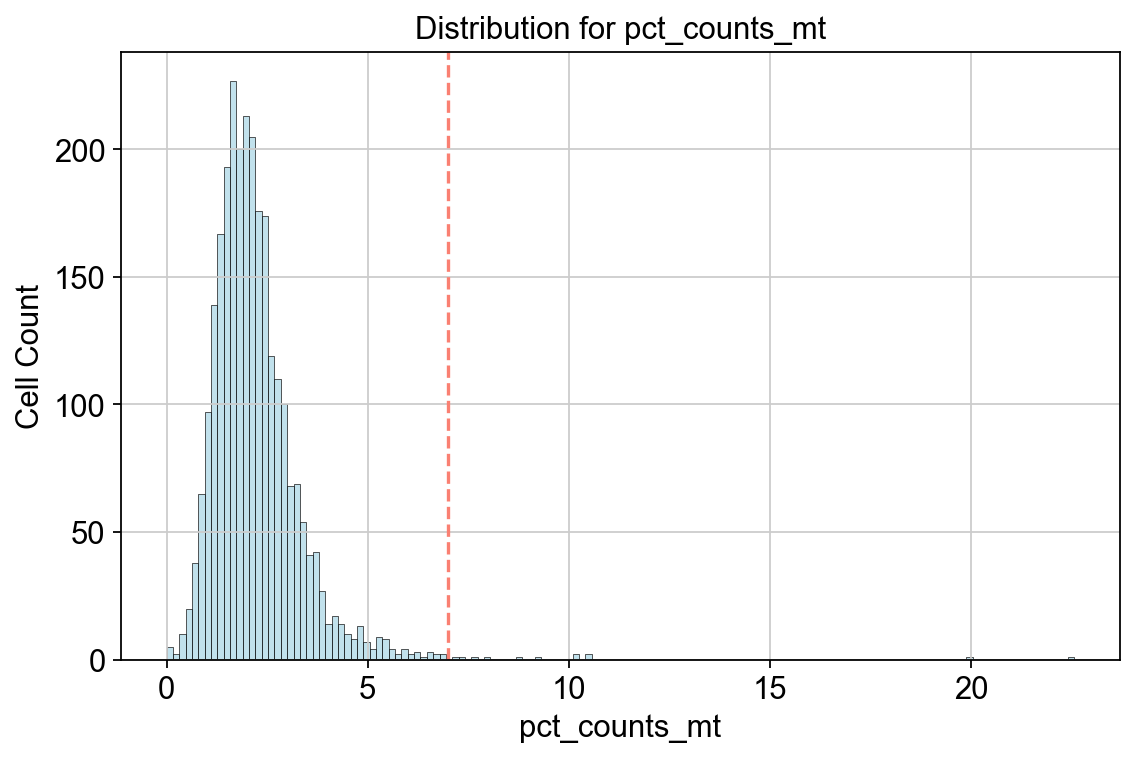

In [7]:
# percentage for mt
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(adata.obs["pct_counts_mt"], color="lightblue", ax=ax)
ax.set_title("Distribution for pct_counts_mt")
ax.set_xlabel("pct_counts_mt")
ax.set_ylabel("Cell Count")
ax.axvline(x=7, color='salmon', linestyle='--')

plt.show()

In [8]:
# another method to combine
# Filtering total_counts
adata_total_counts = adata[
    (adata.obs["total_counts"] > 650) & (adata.obs["total_counts"] < 5500), :
]

# filtering n_genes_by_counts
adata_n_genes = adata[
    (adata.obs["n_genes_by_counts"] > 310) & (adata.obs["n_genes_by_counts"] < 1700), :
]

# filtering pct_counts_mt
adata_mt = adata[adata.obs["pct_counts_mt"] < 7, :]

# common_cells = (
#     set(adata_total_counts.obs_names) & 
#     set(adata_n_genes.obs_names) & 
#     set(adata_mt.obs_names)
# )

# adata_fil = adata[adata.obs_names.isin(common_cells), :]

# print(f"Number of cells after filtering of low quality cells: {adata_fil.n_obs}")

In [9]:
# Detection Doublet
sc.pp.scrublet(adata)

adata_filtered = adata[
    (adata.obs["total_counts"] > 650) & 
    (adata.obs["total_counts"] < 5500) & 
    (adata.obs["n_genes_by_counts"] > 310) & 
    (adata.obs["n_genes_by_counts"] < 1700) & 
    (adata.obs["pct_counts_mt"] < 7) &
    (adata.obs["doublet_score"] < 0.2),
    :
]

print(f"Number of cells after filtering of low quality cells: {adata_filtered.n_obs}")

Number of cells after filtering of low quality cells: 2576


### 3. Normalization

/var/folders/9r/ldn3_2nx38dgrcfn9qqssncm0000gn/T/ipykernel_77556/1043353715.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs["total_counts_raw"] = adata_filtered.X.sum(axis=1)


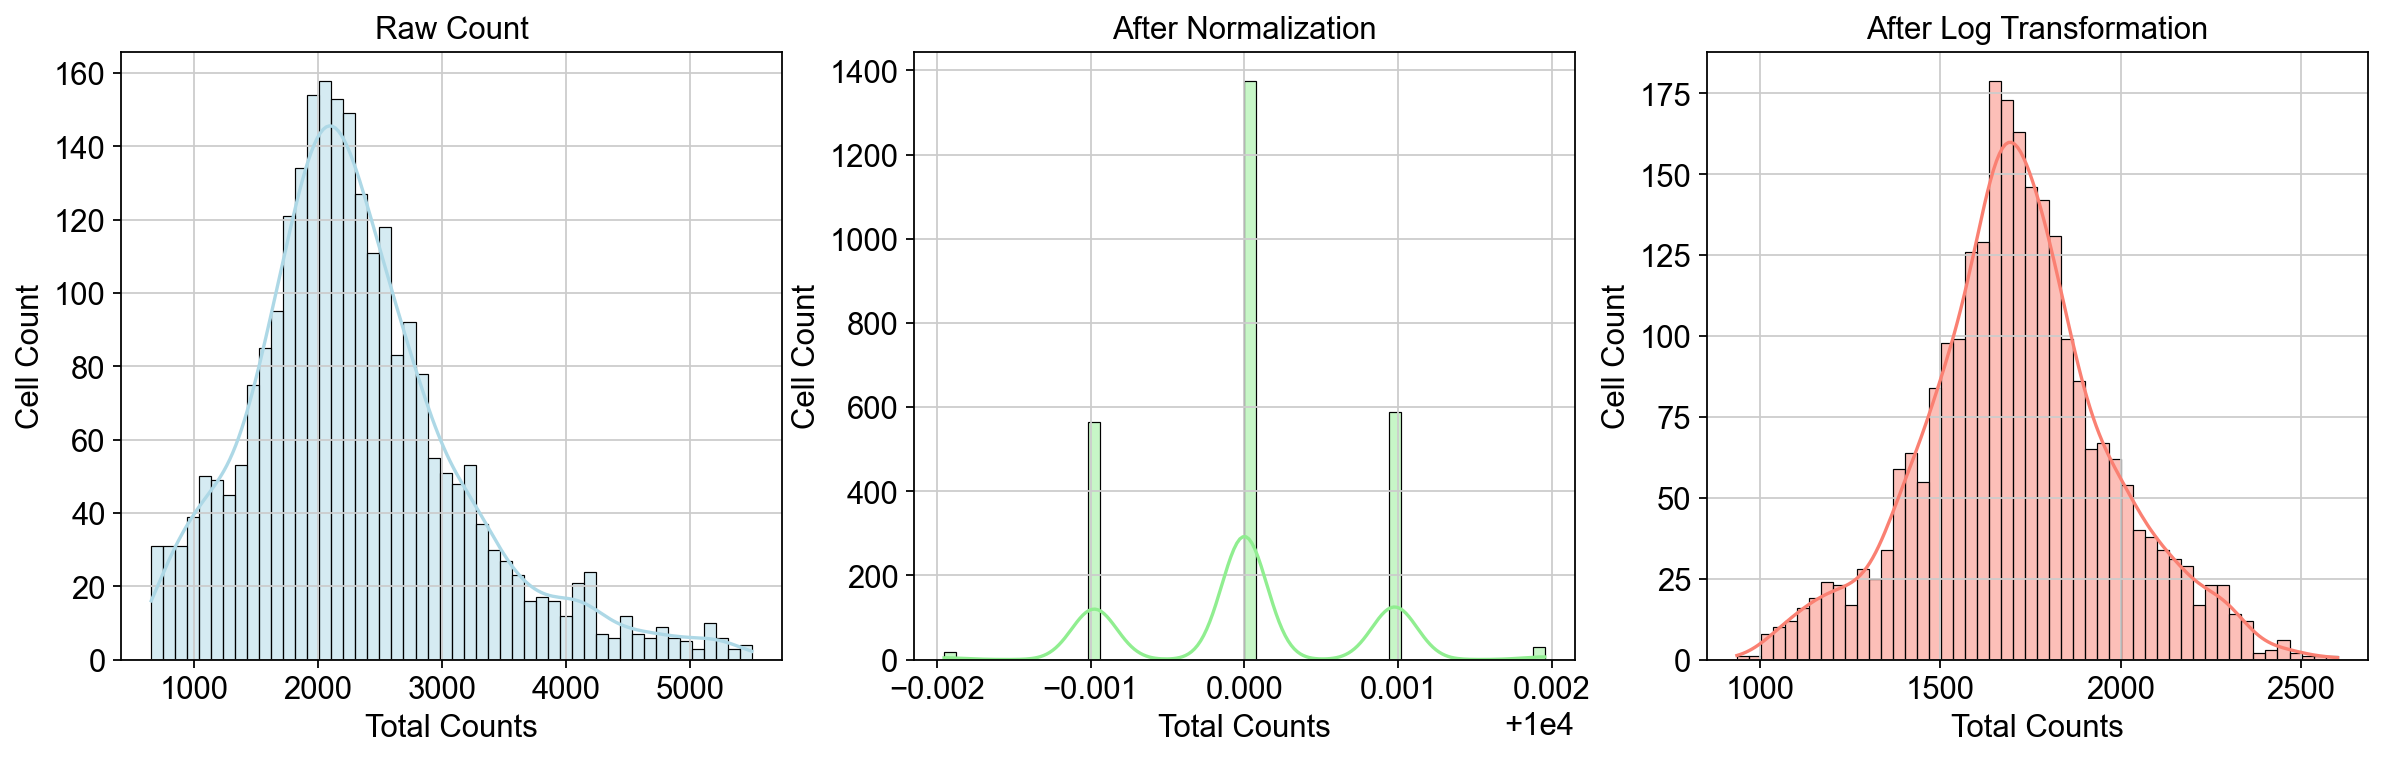

In [10]:
# raw
adata_filtered.obs["total_counts_raw"] = adata_filtered.X.sum(axis=1)

# Normalization
sc.pp.normalize_total(adata_filtered, target_sum=1e4) # Usually choose 1e4, which is 10000 counts
adata_filtered.obs["total_counts_norm"] = adata_filtered.X.sum(axis=1)

# log transformation
sc.pp.log1p(adata_filtered)
adata_filtered.obs["total_counts_log"] = adata_filtered.X.sum(axis=1)

# draw plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# raw data
sns.histplot(adata_filtered.obs["total_counts"], bins=50, kde=True, ax=axes[0], color="lightblue")
axes[0].set_title("Raw Count")
axes[0].set_xlabel("Total Counts")
axes[0].set_ylabel("Cell Count")

# after normalization
sns.histplot(adata_filtered.obs["total_counts_norm"], bins=50, kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("After Normalization")
axes[1].set_xlabel("Total Counts")
axes[1].set_ylabel("Cell Count")

# after transformation
sns.histplot(adata_filtered.obs["total_counts_log"], bins=50, kde=True, ax=axes[2], color="salmon")
axes[2].set_title("After Log Transformation")
axes[2].set_xlabel("Total Counts")
axes[2].set_ylabel("Cell Count")

plt.show()


### 4. Feature Selection

/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


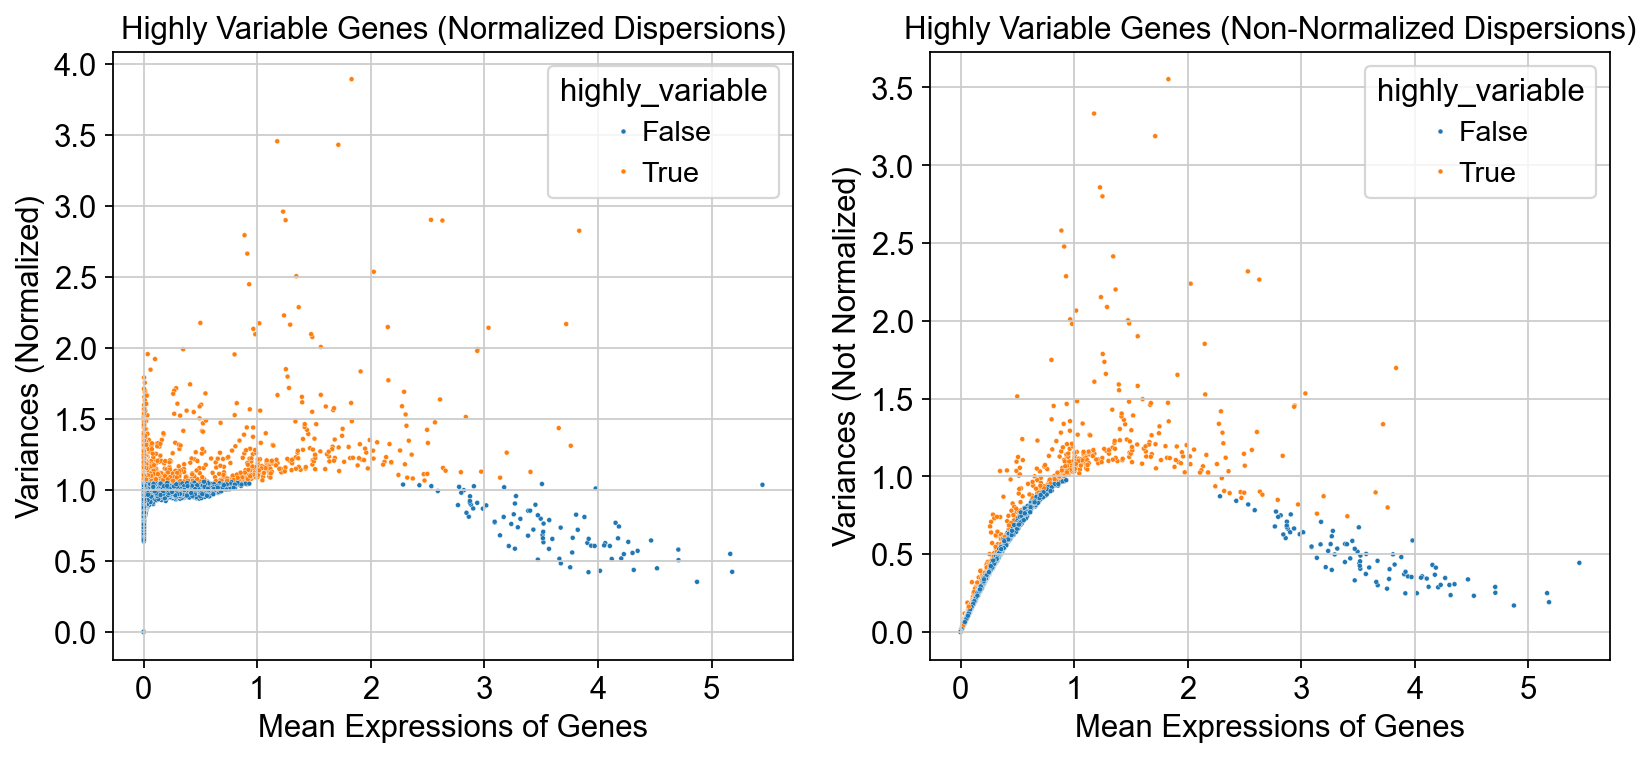

In [11]:
sc.pp.highly_variable_genes(adata_filtered, flavor="seurat_v3", n_top_genes=2000)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(
    data=adata_filtered.var, 
    x="means", 
    y="variances_norm", 
    hue="highly_variable", 
    s=5,
    ax=axes[0]
)
axes[0].set_title("Highly Variable Genes (Normalized Dispersions)")
axes[0].set_xlabel("Mean Expressions of Genes")
axes[0].set_ylabel("Variances (Normalized)")

sns.scatterplot(
    data=adata_filtered.var, 
    x="means", 
    y="variances", 
    hue="highly_variable", 
    s=5,
    ax=axes[1]
)

axes[1].set_title("Highly Variable Genes (Non-Normalized Dispersions)")
axes[1].set_xlabel("Mean Expressions of Genes")
axes[1].set_ylabel("Variances (Not Normalized)")


plt.show()


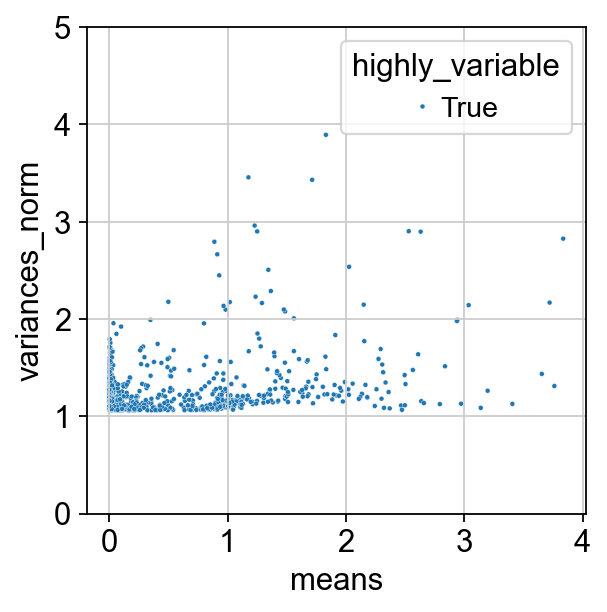

View of AnnData object with n_obs × n_vars = 2576 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'total_counts_raw', 'total_counts_norm', 'total_counts_log'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg'


In [12]:
# filtering low variable genes
adata_filtered = adata_filtered[:, adata_filtered.var["highly_variable"]]
ax = sns.scatterplot(
    data=adata_filtered.var, x="means", y="variances_norm", hue="highly_variable", s=5
)
ax.set_ylim(0, 5)
plt.show()
print(adata_filtered)

### 5. Dimensionality Reduction

/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


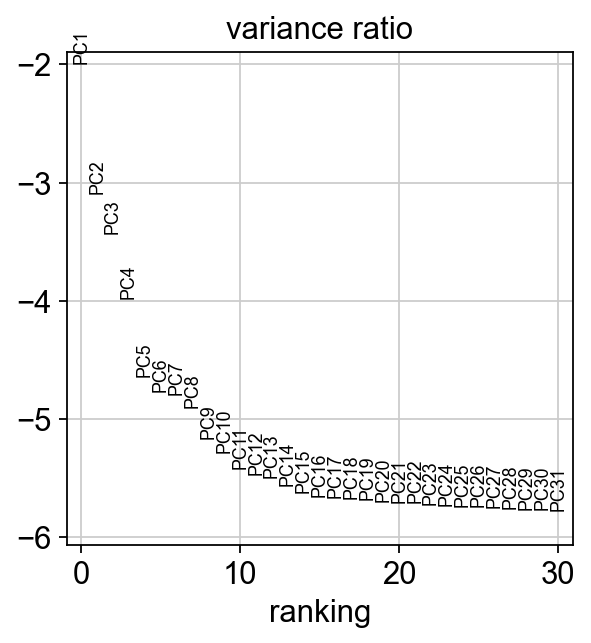

In [13]:
# adata_filtered = adata_filtered.copy() # To aviod ImplicitModificationWarning

# Compute PCA
sc.tl.pca(adata_filtered) # defalut to 50 dimension 
sc.pl.pca_variance_ratio(adata_filtered, log=True) # Usually choose 10-50 PCs

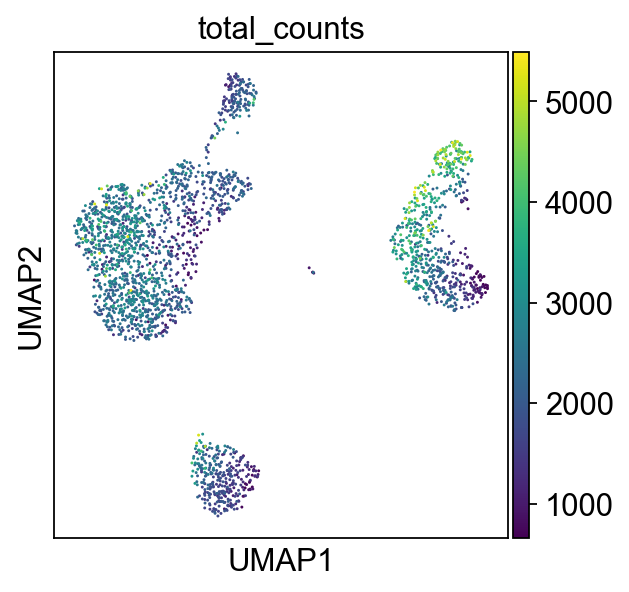

In [14]:
# neighborhood
sc.pp.neighbors(adata_filtered, n_pcs=15)

sc.tl.umap(adata_filtered)

# visualize
sc.pl.umap(adata_filtered, color="total_counts", size=7)

### 6. Clustering

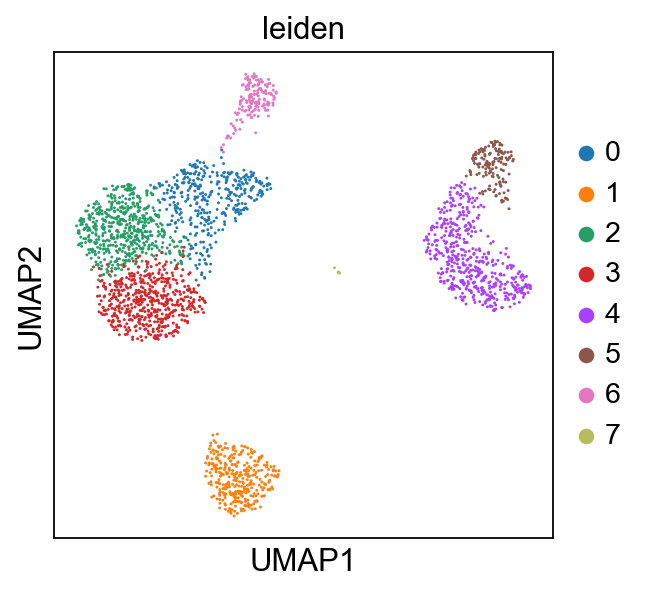

In [15]:
sc.tl.leiden(adata_filtered, flavor="igraph",
             n_iterations=2, resolution=0.5)
sc.pl.umap(adata_filtered, color=["leiden"], size=7)

/var/folders/9r/ldn3_2nx38dgrcfn9qqssncm0000gn/T/ipykernel_77556/3222225591.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered, key_added="leiden_res_0.02", resolution=0.02)


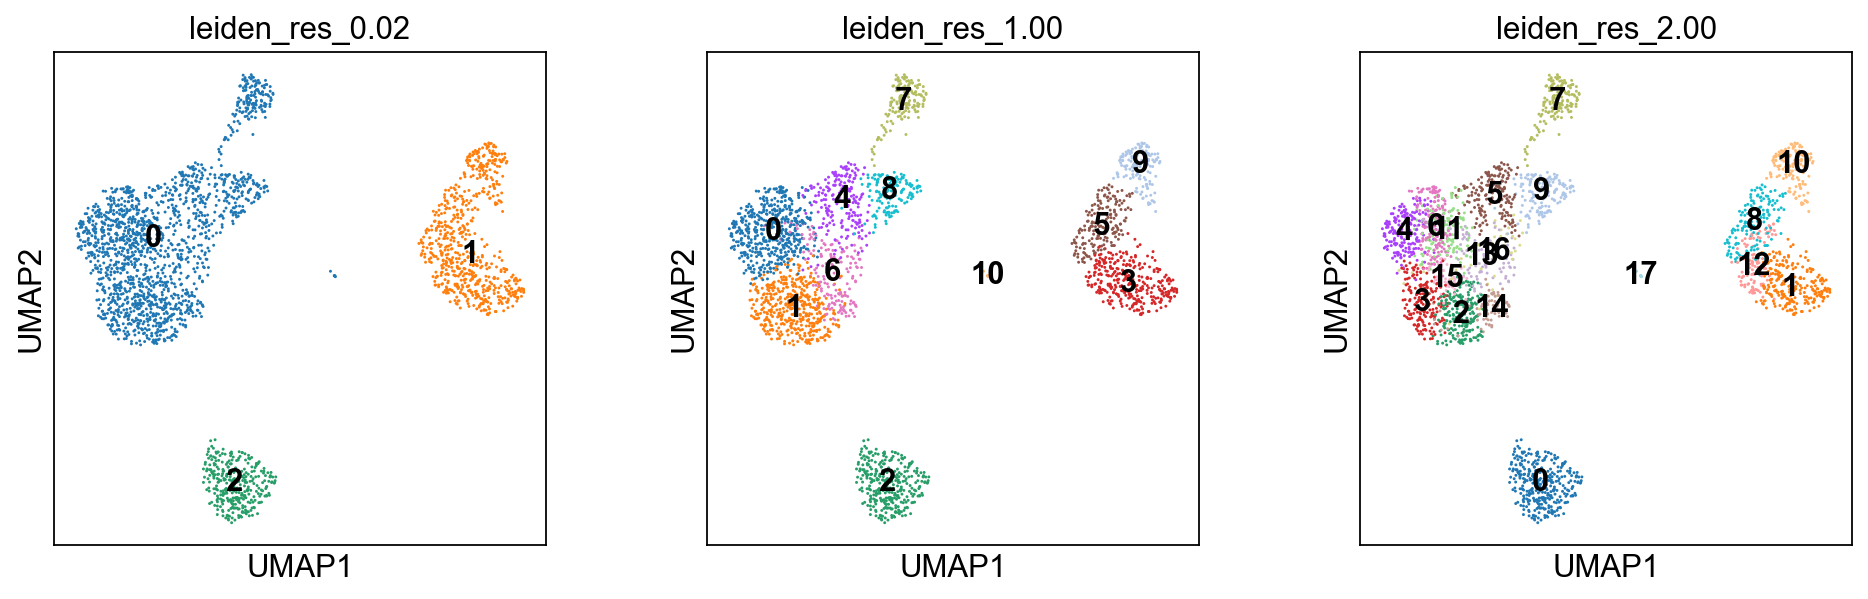

In [16]:
# compare difference resolution
sc.tl.leiden(adata_filtered, key_added="leiden_res_0.02", resolution=0.02)
sc.tl.leiden(adata_filtered, key_added="leiden_res_1.00", resolution=1.0)
sc.tl.leiden(adata_filtered, key_added="leiden_res_2.00", resolution=2.0)

sc.pl.umap(
    adata_filtered,
    color=["leiden_res_0.02", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    size=7,
)

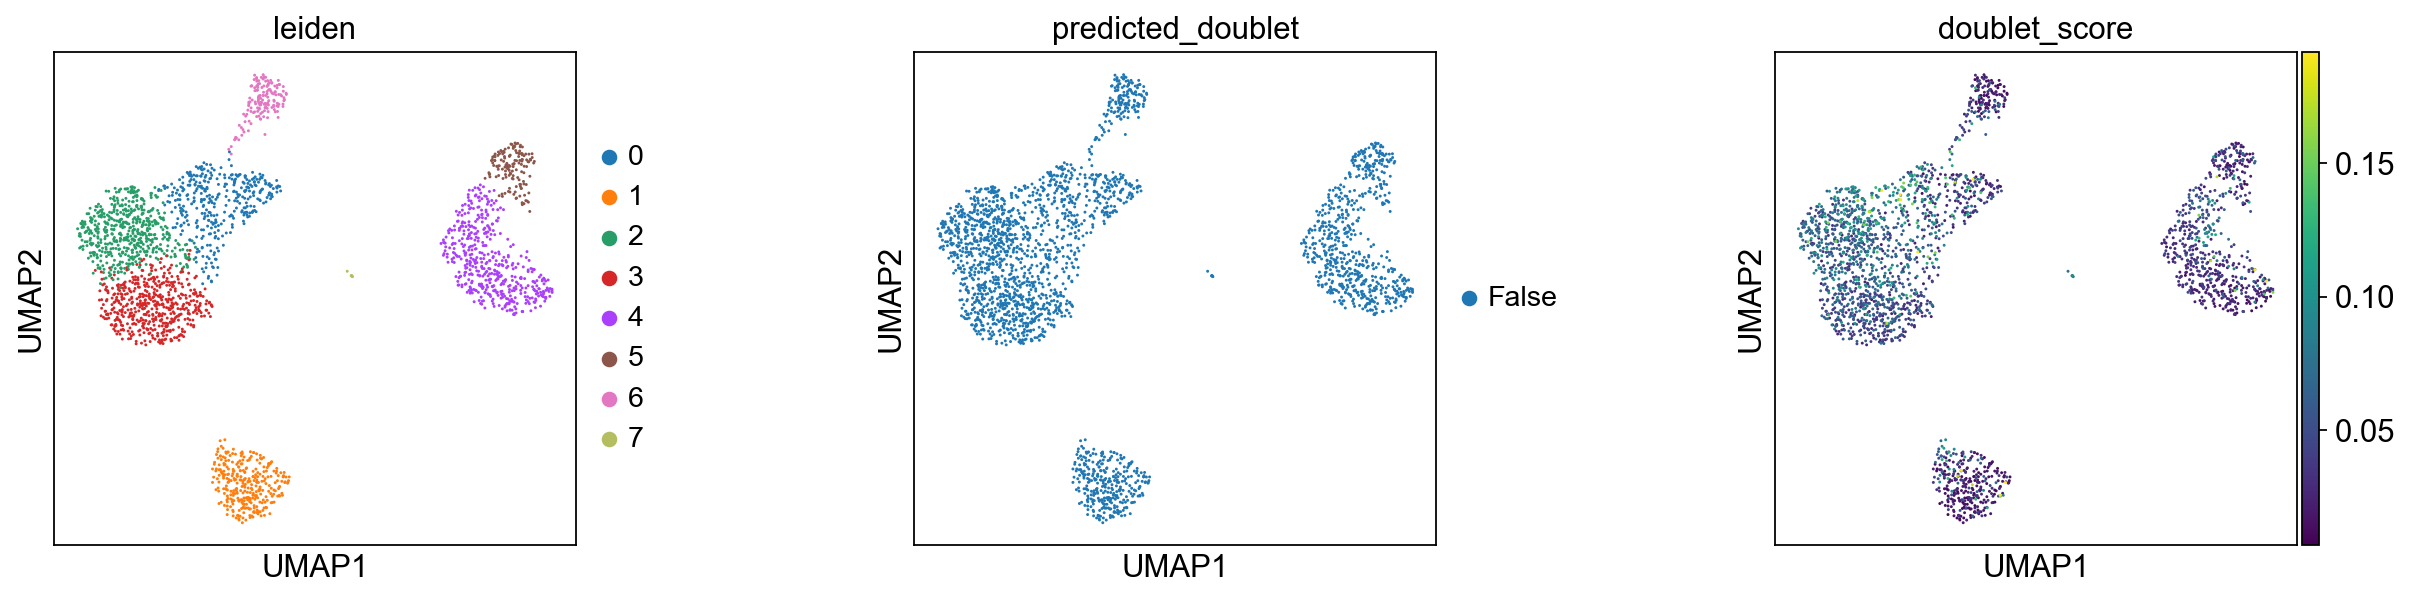

In [17]:
# Re-assess quality control
sc.pl.umap(
    adata_filtered,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=7,
)

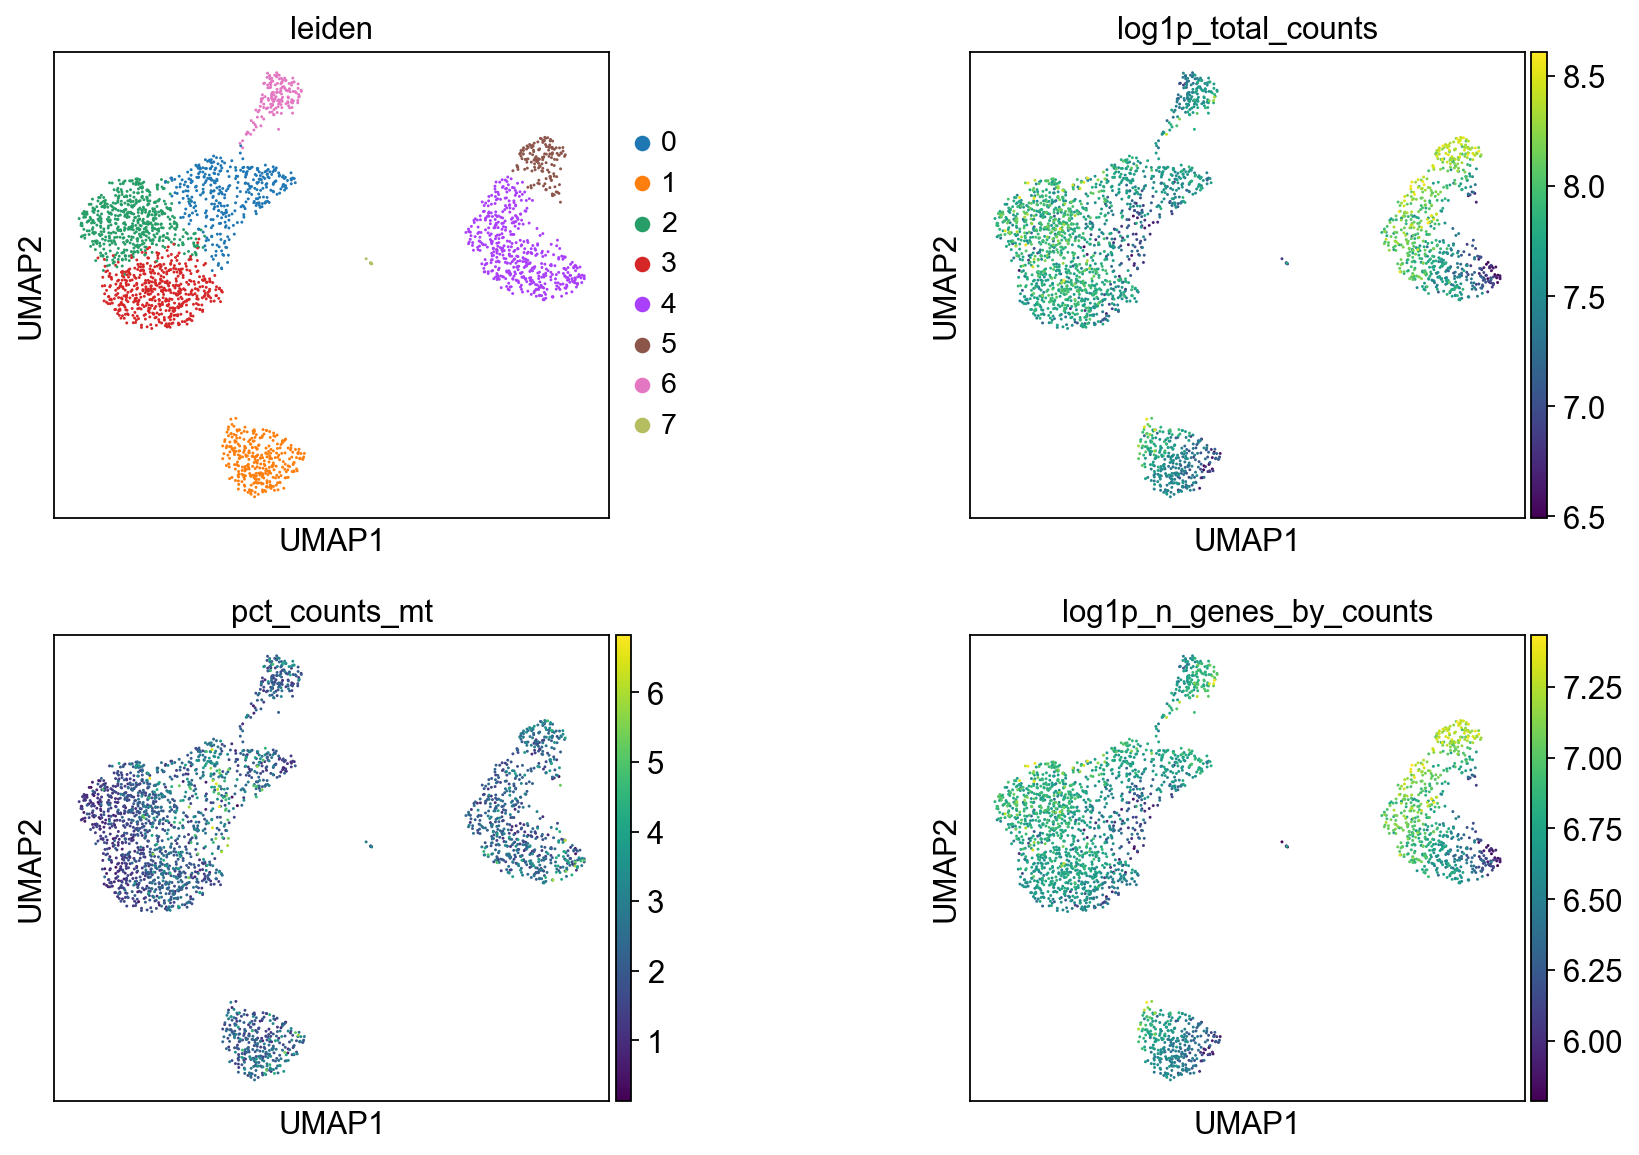

In [18]:
sc.pl.umap(
    adata_filtered,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    size=7,
)

### 7. Marker Gene and Annotation

/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:446: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


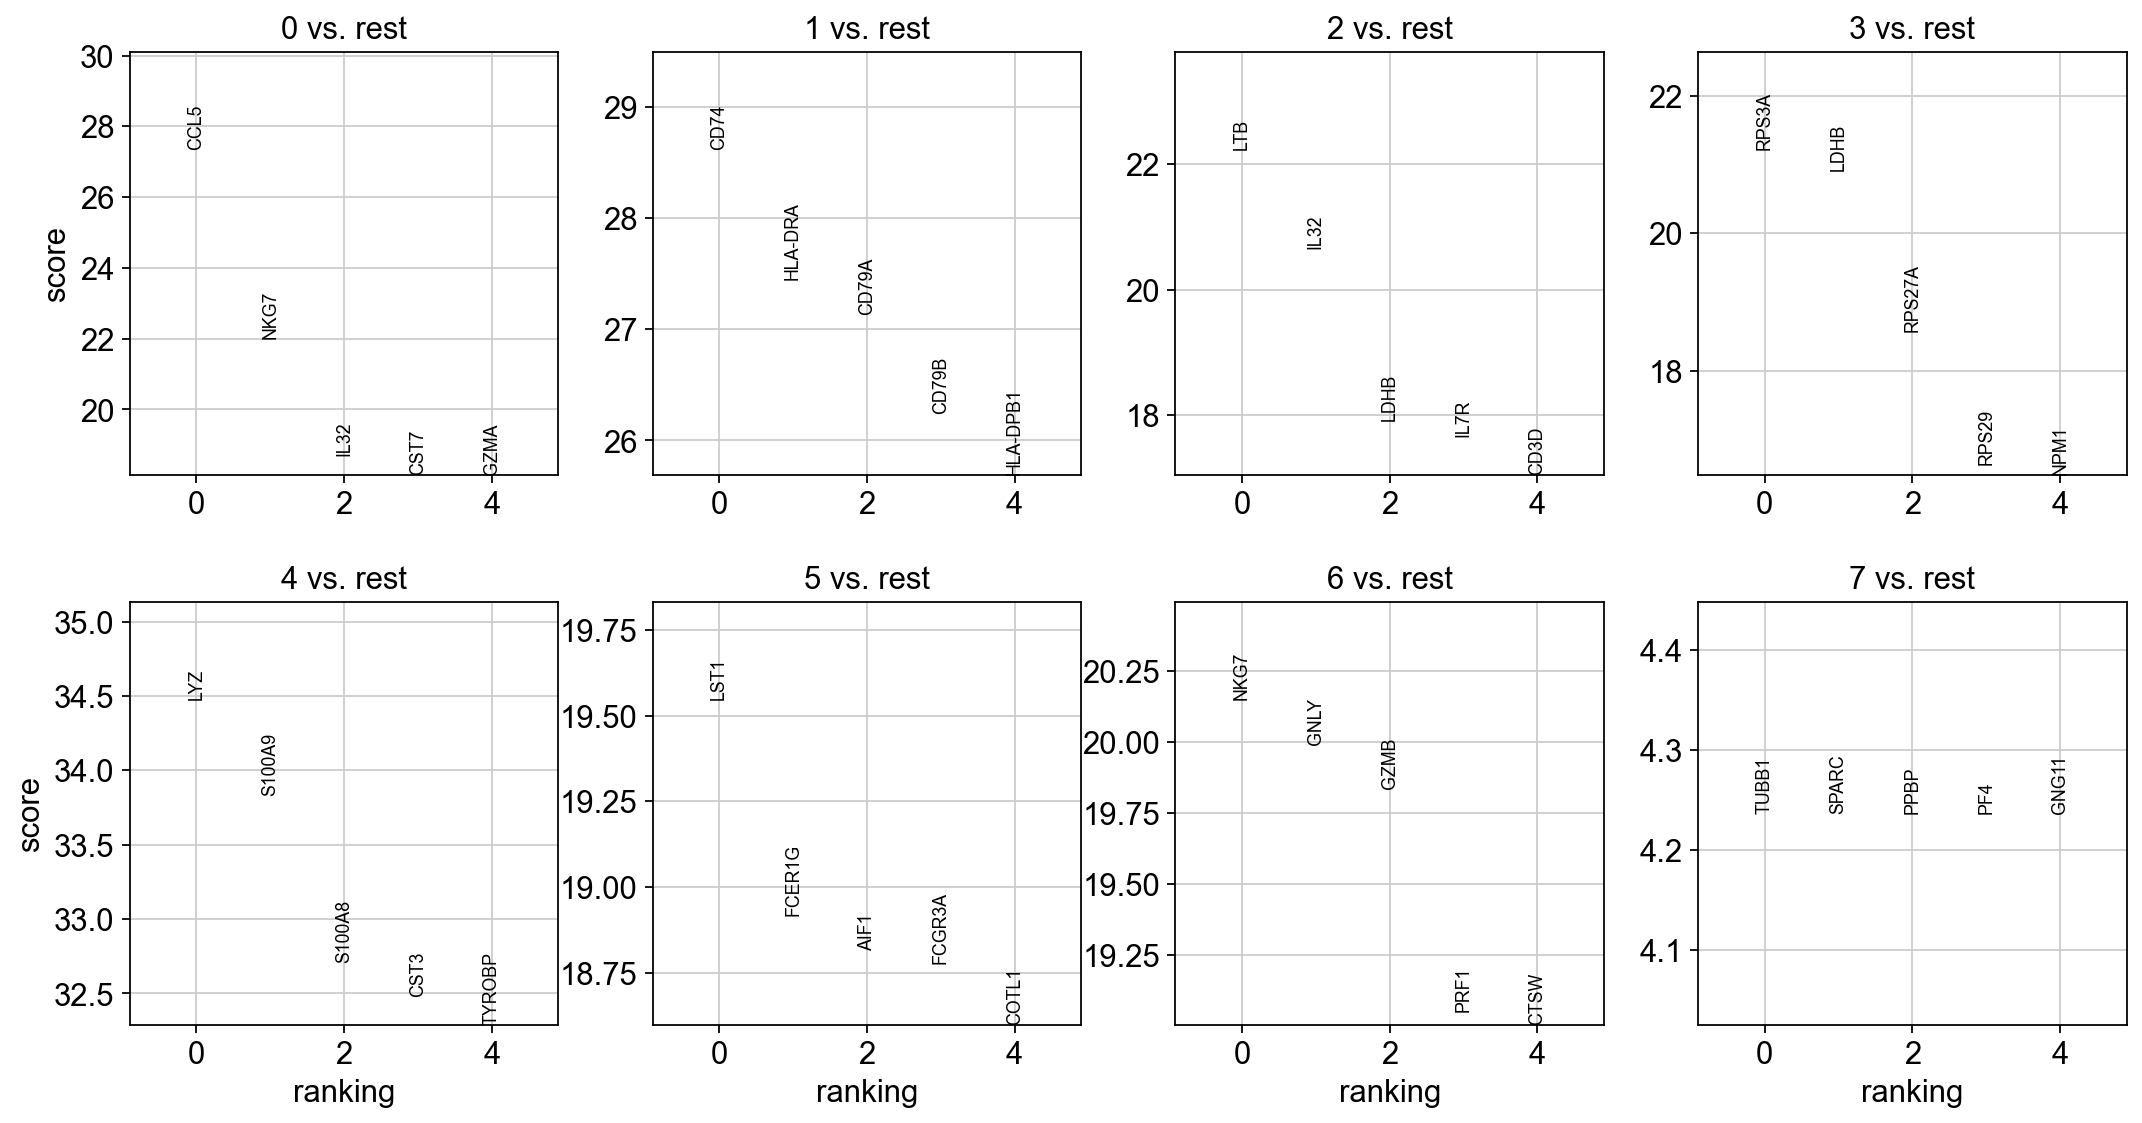

In [19]:
sc.tl.rank_genes_groups(adata_filtered, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_filtered, n_genes=5, sharey=False)


In [20]:
pd.DataFrame(adata_filtered.uns["rank_genes_groups"]["names"]).head(5)

0         1     2       3       4       5     6      7
0  CCL5      CD74   LTB   RPS3A     LYZ    LST1  NKG7  TUBB1
1  NKG7   HLA-DRA  IL32    LDHB  S100A9  FCER1G  GNLY  SPARC
2  IL32     CD79A  LDHB  RPS27A  S100A8    AIF1  GZMB   PPBP
3  CST7     CD79B  IL7R   RPS29    CST3  FCGR3A  PRF1    PF4
4  GZMA  HLA-DPB1  CD3D    NPM1  TYROBP   COTL1  CTSW  GNG11

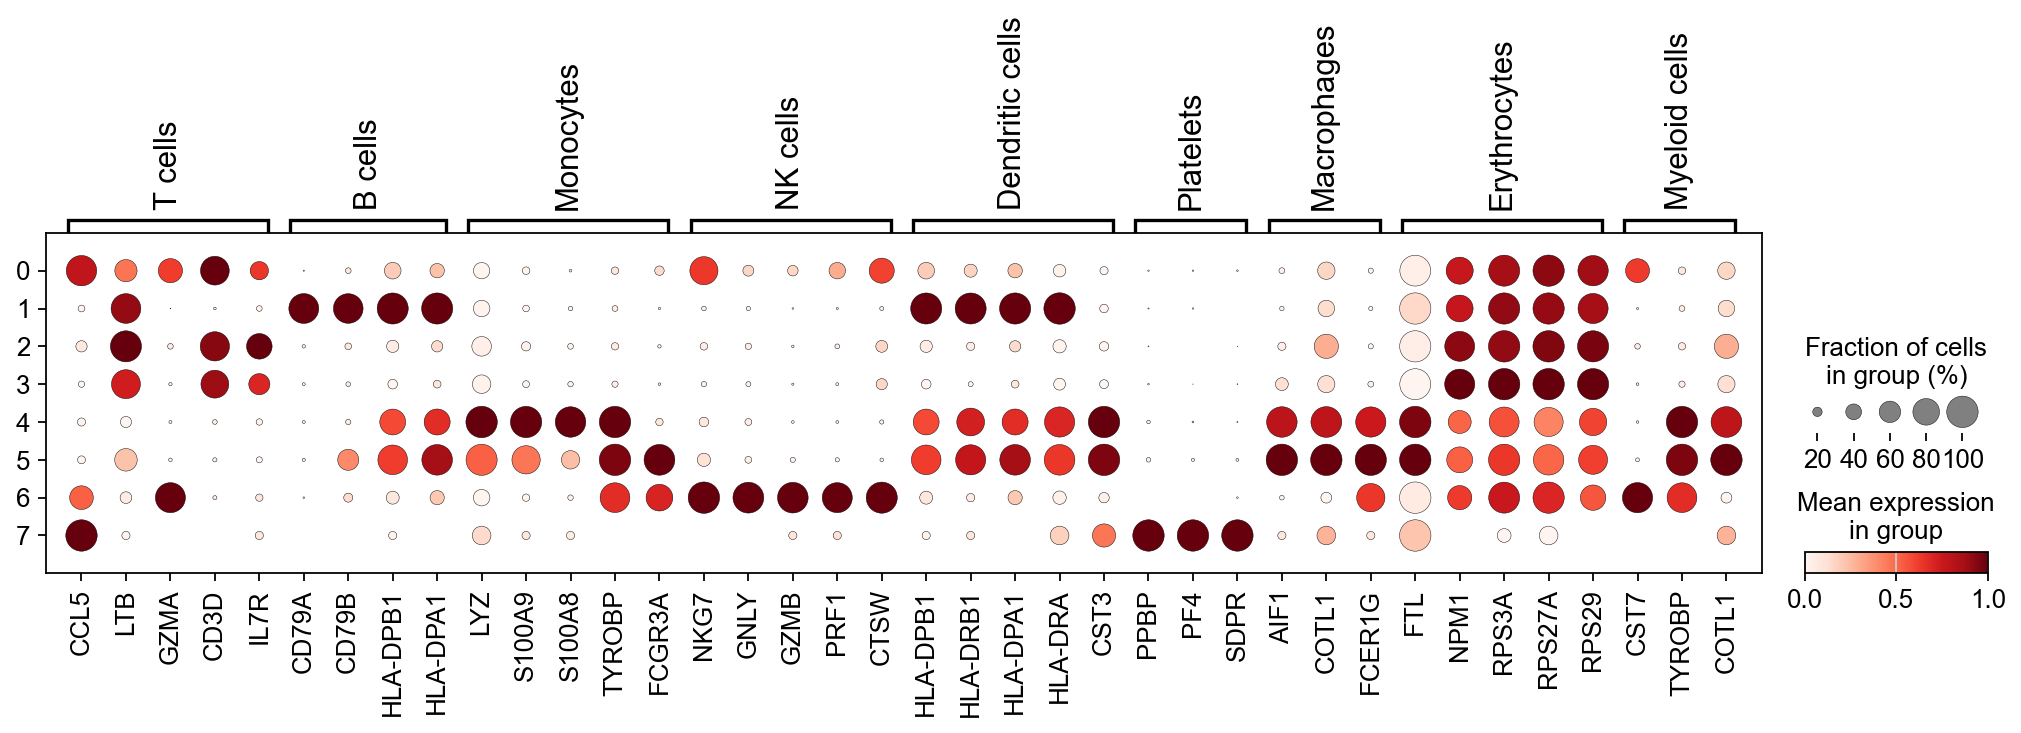

In [21]:
# should start with above marker genes to form the dictionary
# and then by looking at the dotplot, label cluster witeh broad lineages.
marker_genes = {
    "T cells": ["CCL5", "LTB", "GZMA", "CD3D", "IL7R"],
    "B cells": ["CD79A", "CD79B", "HLA-DPB1", "HLA-DPA1"],
    "Monocytes": ["LYZ", "S100A9", "S100A8", "TYROBP", "FCGR3A"],
    "NK cells": ["NKG7", "GNLY", "GZMB", "PRF1", "CTSW"],
    "Dendritic cells": ["HLA-DPB1", "HLA-DRB1", "HLA-DPA1", "HLA-DRA", "CST3"],
    "Platelets": ["PPBP", "PF4", "SDPR"],
    "Macrophages": ["AIF1", "COTL1", "FCER1G"],
    "Erythrocytes": ["FTL", "NPM1", "RPS3A", "RPS27A", "RPS29"],
    "Myeloid cells": ["CST7", "TYROBP", "COTL1"],
}

sc.pl.dotplot(adata_filtered, marker_genes, groupby="leiden", standard_scale="var")

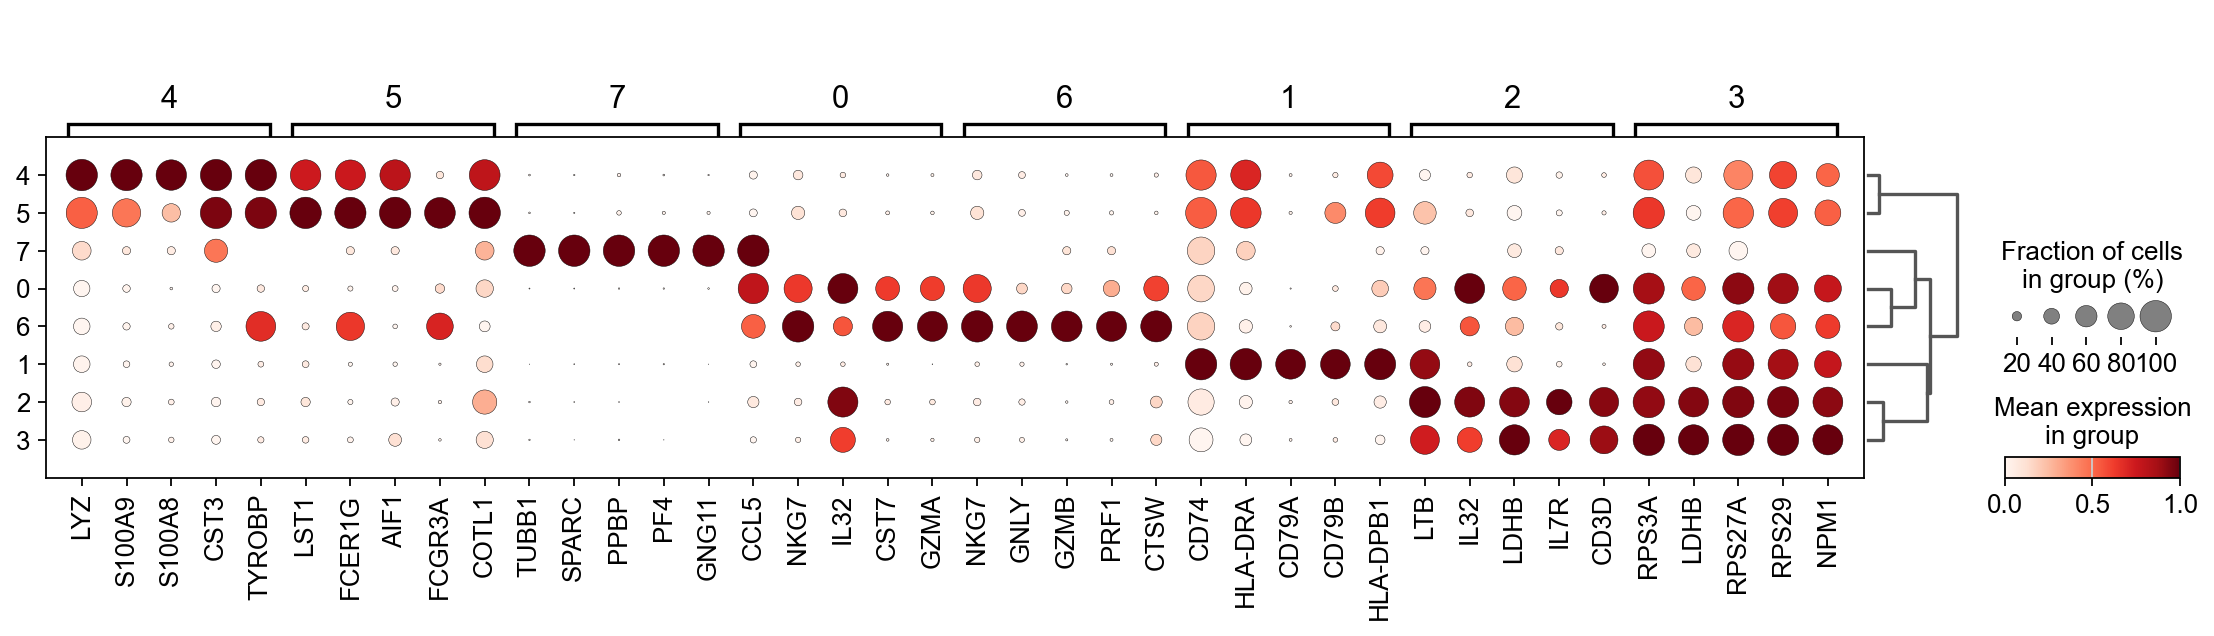

In [22]:
sc.pl.rank_genes_groups_dotplot(
    adata_filtered, groupby="leiden", standard_scale="var", n_genes=5
)


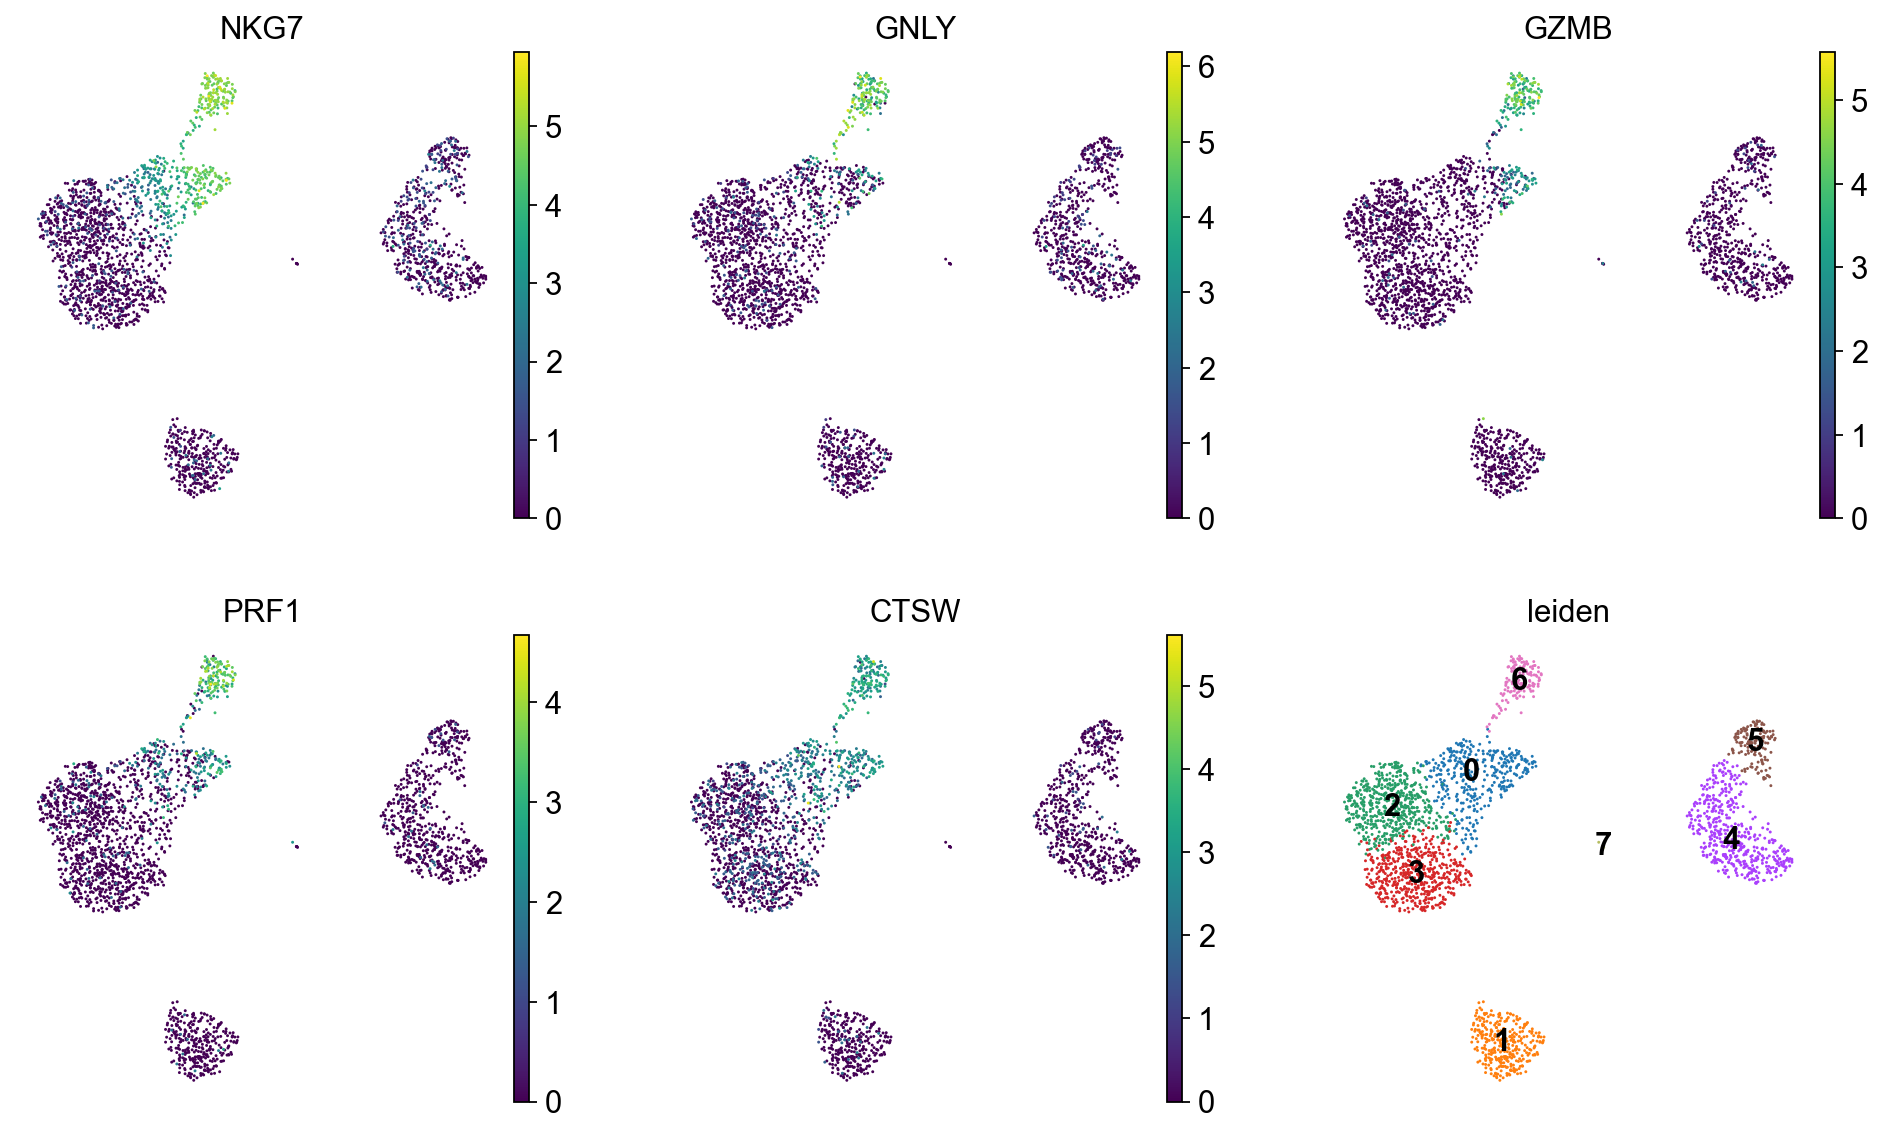

In [23]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata_filtered, group="6").head(5)["names"]
sc.pl.umap(
    adata_filtered,
    color=[*dc_cluster_genes, "leiden"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    size = 7,
)